### Direct links to results
[TF-MoDISco results](#tfm-results)

[Summary of motifs](#motif-summary)

[TOMTOM matches to motifs](#tomtom)

[Sample of seqlets for each motif](#seqlets)

In [3]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
import h5py
import numpy as np
import pandas as pd
import scipy.signal
import sklearn.cluster
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import modisco
import tqdm
tqdm.tqdm_notebook()

/users/amtseng/miniconda3/envs/tfmodisco-mini2/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


0it [00:00, ?it/s]

In [4]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini2/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


## Define constants and paths

In [35]:
tfm_results_paths = [
    "/users/amtseng/tfmodisco/results/tfmodisco/multitask_profile_finetune/E2F6_multitask_profile_finetune_fold1/E2F6_multitask_profile_finetune_fold1_count_tfm.h5"
]

## Helper functions

In [16]:
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the set of all motifs identified by TF-MoDISco.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `trim`: if True, trim the motif flanks based on total importance
        `only_pos`: if True, only return motifs with positive contributions
    Returns a list of PFMs, a list of hCWMs, and a list of CWMs (all as
    NumPy arrays).
    """ 
    pfms, hcwms, cwms = [], [], []
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]

                pfm = pattern["sequence"]["fwd"][:]
                hcwm = pattern["task0_hypothetical_contribs"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]

                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                
                if trim:
                    score = np.sum(np.abs(cwm), axis=1)
                    trim_thresh = np.max(score) * 0.2  # Cut off anything less than 10% of max score
                    pass_inds = np.where(score >= trim_thresh)[0]
                    pfm = pfm[np.min(pass_inds): np.max(pass_inds) + 1]
                    hcwm = hcwm[np.min(pass_inds): np.max(pass_inds) + 1]
                    cwm = cwm[np.min(pass_inds): np.max(pass_inds) + 1]

                pfms.append(pfm)
                hcwms.append(hcwm)
                cwms.append(cwm)

    return pfms, hcwms, cwms

In [28]:
def motif_similarity(motif_1, motif_2):
    """
    Computes similarity of the two motifs (given as an N x 4 array
    and an M x 4 array), and returns the scalar similarity.
    """
    # Note that we take every sliding window in the dimension of the motif
    # lenght, but we always make sure the base dimension lines up
    return np.max(scipy.signal.correlate(motif_1, motif_2)[:, 3])

In [32]:
def motif_similarity_matrix(motifs):
    """
    Given a list of various N x 4 arrays of motifs (where N could be
    different for each motif), computes the (symmetric) similarity
    matrix. The diagonal is all 0 by default.
    """
    num_motifs = len(motifs)
    matrix = np.zeros((num_motifs, num_motifs))
    for i in tqdm.notebook.trange(num_motifs):
        for j in range(i + 1, num_motifs):
            sim = motif_similarity(motifs[i], motifs[j])
            matrix[i][j] = sim
            matrix[j][i] = sim
    return matrix

In [50]:
background_freqs = np.array([0.25, 0.25, 0.25, 0.25])
def info_content(track, pseudocount=0.001):
    """
    Given an L x 4 track, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = track.shape[1]
    # Normalize track to probabilities along base axis
    track_norm = (track + pseudocount) / (np.sum(track, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = track_norm * np.log2(track_norm / np.expand_dims(background_freqs, axis=0))
    return np.sum(ic, axis=1)

In [48]:
def pfm_to_pwm(pfm):
    ic = info_content(pfm)
    return pfm * np.expand_dims(ic, axis=1)

### Import TF-MoDISco PFMs

In [36]:
pfms, hcwms, cwms = import_tfmodisco_motifs(tfm_results_paths[0])

In [44]:
def save_jaspar_pfms(pfms, names, outdir):
    assert len(pfms) == len(names)
    os.makedirs(outdir, exist_ok=True)
    for pfm, name in zip(pfms, names):
        with open(os.path.join(outdir, name + ".pfm"), "w") as f:
            for i in range(4):
                f.write("\t".join([str(x) for x in pfm[:, i]]) + "\n")

In [45]:
outdir = "/mnt/lab_data2/amtseng/share/vivek/E2F6_multitask_profile_finetune_fold1_count_tfm_motifs"
names = ["motif_%d" % i for i in range(len(pfms))]
save_jaspar_pfms(pfms, names, outdir)

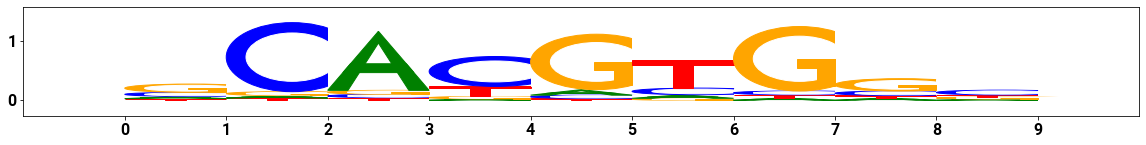

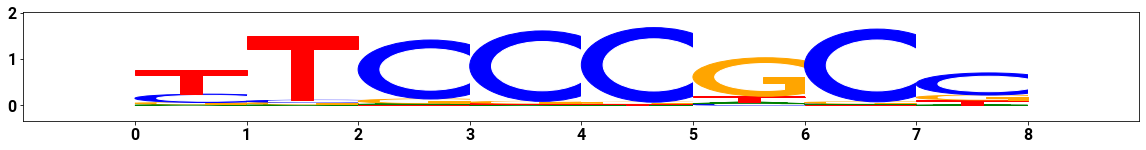

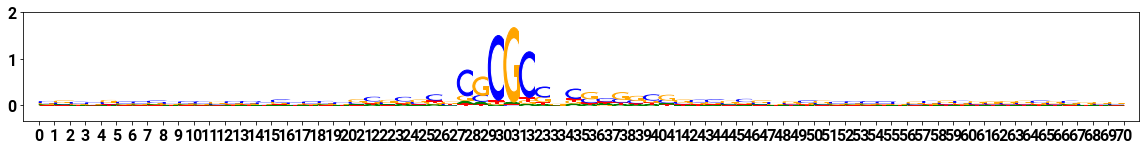

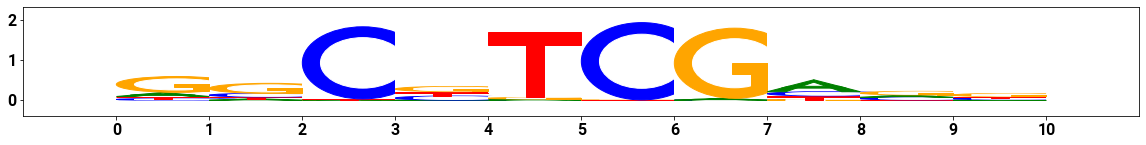

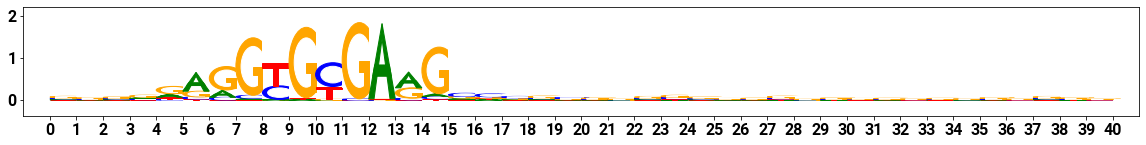

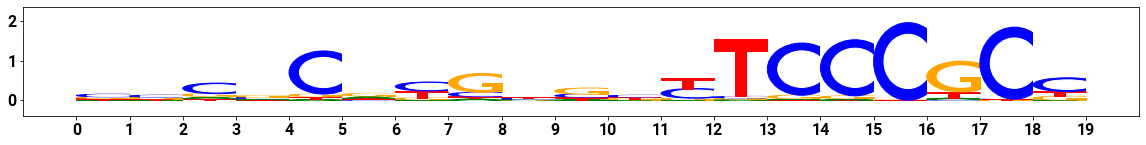

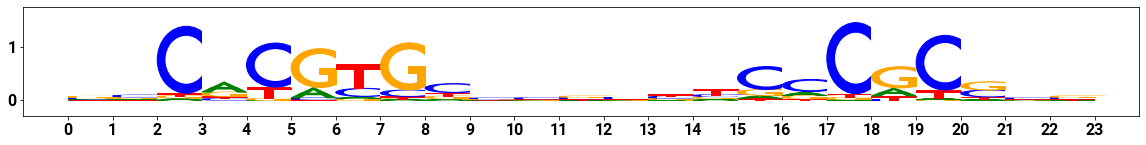

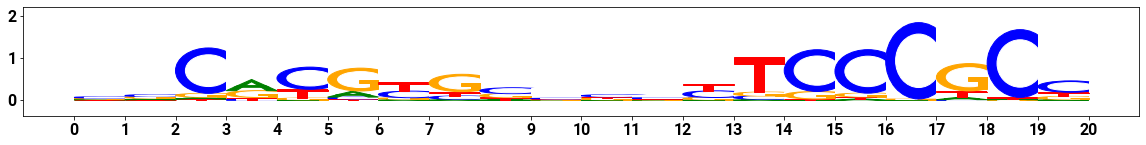

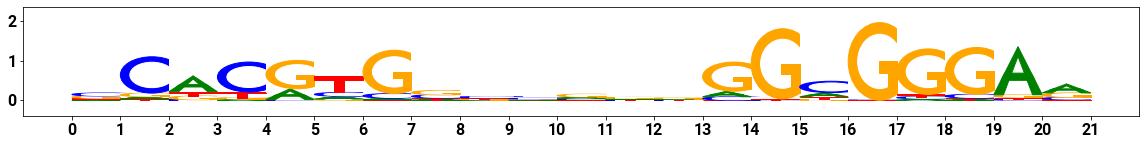

In [51]:
for pfm in pfms:
    viz_sequence.plot_weights(pfm_to_pwm(pfm))

In [37]:
matrix = motif_similarity_matrix(pfms)

In [38]:
matrix

array([[ 0.        ,  2.67251077,  3.61476894,  3.01938093,  3.59902616,
         3.81163089,  4.57157922,  4.29105961,  4.7205754 ],
       [ 2.67251077,  0.        ,  4.34014489,  2.88403656,  2.31812252,
         6.03759424,  4.54976054,  5.67447559,  2.67266265],
       [ 3.61476894,  4.34014489,  0.        ,  3.94183624, 11.9881056 ,
         7.41701438,  7.86742916,  7.67810853,  7.4781502 ],
       [ 3.01938093,  2.88403656,  3.94183624,  0.        ,  4.01209526,
         3.8121581 ,  3.40665635,  3.54223188,  3.32041902],
       [ 3.59902616,  2.31812252, 11.9881056 ,  4.01209526,  0.        ,
         5.79080317,  7.14994972,  6.00529031,  6.88370871],
       [ 3.81163089,  6.03759424,  7.41701438,  3.8121581 ,  5.79080317,
         0.        ,  8.03745828,  8.29187664,  5.40286648],
       [ 4.57157922,  4.54976054,  7.86742916,  3.40665635,  7.14994972,
         8.03745828,  0.        ,  7.57303175,  7.16663049],
       [ 4.29105961,  5.67447559,  7.67810853,  3.54223188,  6

In [27]:
np.max(scipy.signal.correlate(pfms[0], pfms[1]))

3.022480496250419

### Cluster PFMs
Use simple cross-correlation

### Plot clusters